In [43]:
import uuid, sys, os
import requests
import random
import pandas as pd
import math
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, trange
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy import stats

from transformers import EsmModel, AutoTokenizer # huggingface
import esm

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
torch.manual_seed(0)
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
from accelerate import Accelerator
import training_utils.partitioning_utils as pat_utils
from torch.utils.checkpoint import checkpoint

# LoRA
from peft import LoraConfig, get_peft_model

Tesla V100-SXM2-32GB


#### ESM-2 boosted

In [2]:
api = wandb.Api()
run = api.run("/s232958-danmarks-tekniske-universitet-dtu/CSSP_ESM_2vsESM_IF/runs/nu2h1uyg")

rows = []
for row in run.scan_history():
    rows.append(row)

Df_esm2boosted = pd.DataFrame(rows)[[    
    "PPint Train-loss",
    "PPint Test-Loss",
    "PPint Accuracy",
    "PPint non-dimer AUROC",
    "PPint non-dimer AUPR",
    "Meta Val-loss",
    "Meta Accuracy",
    "Meta Val-AUROC",
    "Meta Val-AUPR",
    ]]
Df_esm2boosted.to_csv("c544a74-3146-48df-ae41-cb8ff5567f82_logs.csv", index=False)
Df_esm2boosted

,PPint Train-loss,PPint Test-Loss,PPint Accuracy,PPint non-dimer AUROC,PPint non-dimer AUPR,Meta Val-loss,Meta Accuracy,Meta Val-AUROC,Meta Val-AUPR
0,NaN,3.448614,0.856,0.675343,0.450057,5.080181,0.110702,0.463863,0.095175
1,0.509261,0.204053,0.870,0.789582,0.514703,0.399447,0.870328,0.498641,0.107231
2,0.232553,0.180070,0.890,0.830096,0.550316,0.515966,0.787089,0.470574,0.099432
3,0.172188,0.172352,0.886,0.840065,0.555587,0.396592,0.872027,0.534616,0.148972
4,0.149302,0.171369,0.886,0.845883,0.553598,0.388344,0.884768,0.534335,0.149718
5,0.126828,0.173689,0.900,0.856580,0.571228,0.394670,0.877690,0.550808,0.144875
6,0.105237,0.172024,0.888,0.851944,0.567896,0.481535,0.787089,0.550261,0.133933
7,0.092581,0.173303,0.894,0.847459,0.560547,0.443215,0.832673,0.530425,0.130507
8,0.084063,0.178819,0.904,0.856459,0.569323,0.412399,0.876274,0.530919,0.122843
9,0.078304,0.190841,0.902,0.850838,0.576318,0.418087,0.869479,0.529790,0.119886


#### Original ESM-2

In [3]:
api = wandb.Api()
run = api.run("/s232958-danmarks-tekniske-universitet-dtu/CSSP_ESM_2vsESM_IF/runs/9kxd7sxu")

rows = []
for row in run.scan_history():
    rows.append(row)

Dfesm2original = pd.DataFrame(rows)[[    
    "PPint Train-loss",
    "PPint Test-Loss",
    "PPint Accuracy",
    "PPint non-dimer AUROC",
    "PPint non-dimer AUPR",
    "Meta Val-loss",
    "Meta Accuracy",
    "Meta Val-AUROC",
    "Meta Val-AUPR",
    ]]
Dfesm2original.to_csv("7241047c-e9aa-48c7-8712-b7aee3421310_logs.csv", index=False)
Dfesm2original

,PPint Train-loss,PPint Test-Loss,PPint Accuracy,PPint non-dimer AUROC,PPint non-dimer AUPR,Meta Val-loss,Meta Accuracy,Meta Val-AUROC,Meta Val-AUPR
0,NaN,6.248908,0.838,0.648889,0.384316,10.400999,0.110702,0.511942,0.127292
1,0.555480,0.228394,0.860,0.754629,0.471302,0.434362,0.884202,0.478398,0.110201
2,0.238915,0.218667,0.882,0.767462,0.474203,0.477860,0.861552,0.472167,0.101334
3,0.190010,0.220873,0.874,0.785370,0.484011,0.441172,0.888732,0.493072,0.117772
4,0.161587,0.203391,0.874,0.802127,0.492485,0.477843,0.888448,0.516154,0.138142
5,0.136346,0.194450,0.888,0.807430,0.524702,0.478975,0.857588,0.513944,0.124257
6,0.123512,0.241083,0.890,0.816006,0.532354,0.487117,0.888732,0.541498,0.137111
7,0.108301,0.216316,0.888,0.816203,0.521959,0.534941,0.887599,0.534961,0.144778
8,0.101913,0.260435,0.886,0.811688,0.509074,0.556237,0.887033,0.545536,0.133076
9,0.083452,0.198692,0.892,0.825233,0.520384,0.442261,0.883918,0.574474,0.142233


#### Original ESM-C

In [4]:
# api = wandb.Api()
# run = api.run("/s232958-danmarks-tekniske-universitet-dtu/CSSP_ESM_2vsESM_IF/runs/9kxd7sxu")

# rows = []
# for row in run.scan_history():
#     rows.append(row)

# DfesmCoriginal = pd.DataFrame(rows)[[    
#     "PPint Train-loss",
#     "PPint Test-Loss",
#     "PPint Accuracy",
#     "PPint non-dimer AUROC",
#     "PPint non-dimer AUPR",
#     "Meta Val-loss",
#     "Meta Accuracy",
#     "Meta Val-AUROC",
#     "Meta Val-AUPR",
#     ]]
# DfesmCoriginal.to_csv("7241047c-e9aa-48c7-8712-b7aee3421310_logs.csv", index=False)
# DfesmCoriginal

#### Original ESM-IF

In [4]:
api = wandb.Api()
run = api.run("/s232958-danmarks-tekniske-universitet-dtu/CSSP_ESM_2vsESM_IF/runs/ypbe0elx")

rows = []
for row in run.scan_history():
    rows.append(row)

DfesmIForiginal = pd.DataFrame(rows)[[    
    "PPint Train-loss",
    "PPint Test-Loss",
    "PPint Accuracy",
    "PPint non-dimer AUROC",
    "PPint non-dimer AUPR",
    "Meta Val-loss",
    "Meta Accuracy",
    "Meta Val-AUROC",
    "Meta Val-AUPR",
    ]]
DfesmIForiginal.to_csv("7241047c-e9aa-48c7-8712-b7aee3421310_logs.csv", index=False)
DfesmIForiginal

,PPint Train-loss,PPint Test-Loss,PPint Accuracy,PPint non-dimer AUROC,PPint non-dimer AUPR,Meta Val-loss,Meta Accuracy,Meta Val-AUROC,Meta Val-AUPR
0,NaN,5.484190,0.871227,0.704948,0.473081,8.443625,0.110702,0.530558,0.200153
1,0.540486,0.197592,0.909457,0.856777,0.575930,0.450884,0.836070,0.553532,0.207039
2,0.194028,0.172615,0.919517,0.868762,0.592286,0.399835,0.871461,0.556314,0.181615
3,0.153326,0.148788,0.933602,0.888867,0.619582,0.513524,0.771234,0.576641,0.212089
4,0.124984,0.154103,0.933602,0.885564,0.627421,0.406802,0.863533,0.585810,0.185771
5,0.097867,0.140203,0.935614,0.894488,0.644532,0.515719,0.764723,0.575950,0.198914
6,0.081152,0.151032,0.939638,0.894821,0.640345,0.438380,0.835787,0.574944,0.184352
7,0.071934,0.139849,0.935614,0.892670,0.644743,0.441968,0.836070,0.559723,0.167229
8,0.059547,0.156330,0.937626,0.895003,0.651666,0.424477,0.843998,0.605154,0.189646
9,0.055701,0.165428,0.943662,0.900897,0.668180,0.435100,0.862684,0.559688,0.178144


#### Loading attention scores before after model trianing

In [5]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [6]:
random_sequence = 'RAELEAAAEAARAAAAARGHRMEYWFWKGTVAVLVSPRTPEVEALLAELRAAAAAAGYGLSVGAL'

## Loss= CLIP-loss + 0.5 token-level Loss

In [7]:
original_encoder = ESM2EncoderLoRA()
original_encoder.to("cuda")
original_encoder.eval()

### Training seq_down for 60 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_OldLoss/39c990f3-0db5-430a-8095-075f38a5e808/seq_encoder_cos-sim0.35.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")

seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to("cuda")
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_OldLoss/39c990f3-0db5-430a-8095-075f38a5e808/seq_down_cos-sim0.35.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")

seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to("cuda")
seq_down.eval()

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

In [8]:
### BEfore PEFT
attentions_before = original_encoder.get_attentions([random_sequence])
embeddings_before = original_encoder.forward([random_sequence])

### After PEFT
attentions_after = seq_encoder.get_attentions([random_sequence])
embeddings_after = seq_encoder.forward([random_sequence])

### All heads

In [9]:
avg_last8_layers_before = []
for layer_attn in attentions_before[-12:]:
    A = layer_attn[0][:, 1:-1, 1:-1]       # [H, T, T]
    avg_last8_layers_before.append(A.mean(dim=0)) # [T, T]

avg_last8_layers_after = []
for layer_attn in attentions_after[-12:]:
    A = layer_attn[0][:, 1:-1, 1:-1]       # [H, T, T]
    avg_last8_layers_after.append(A.mean(dim=0)) # [T, T]

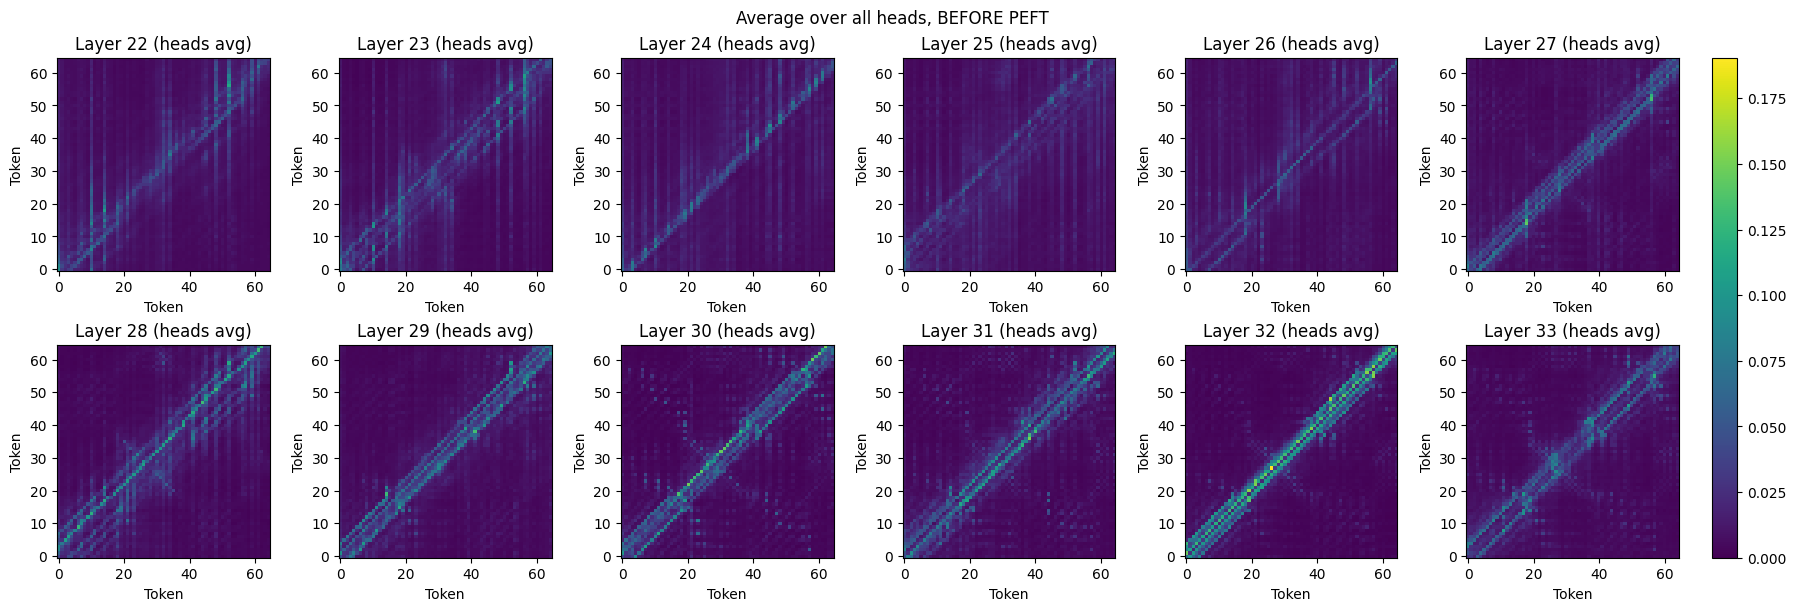

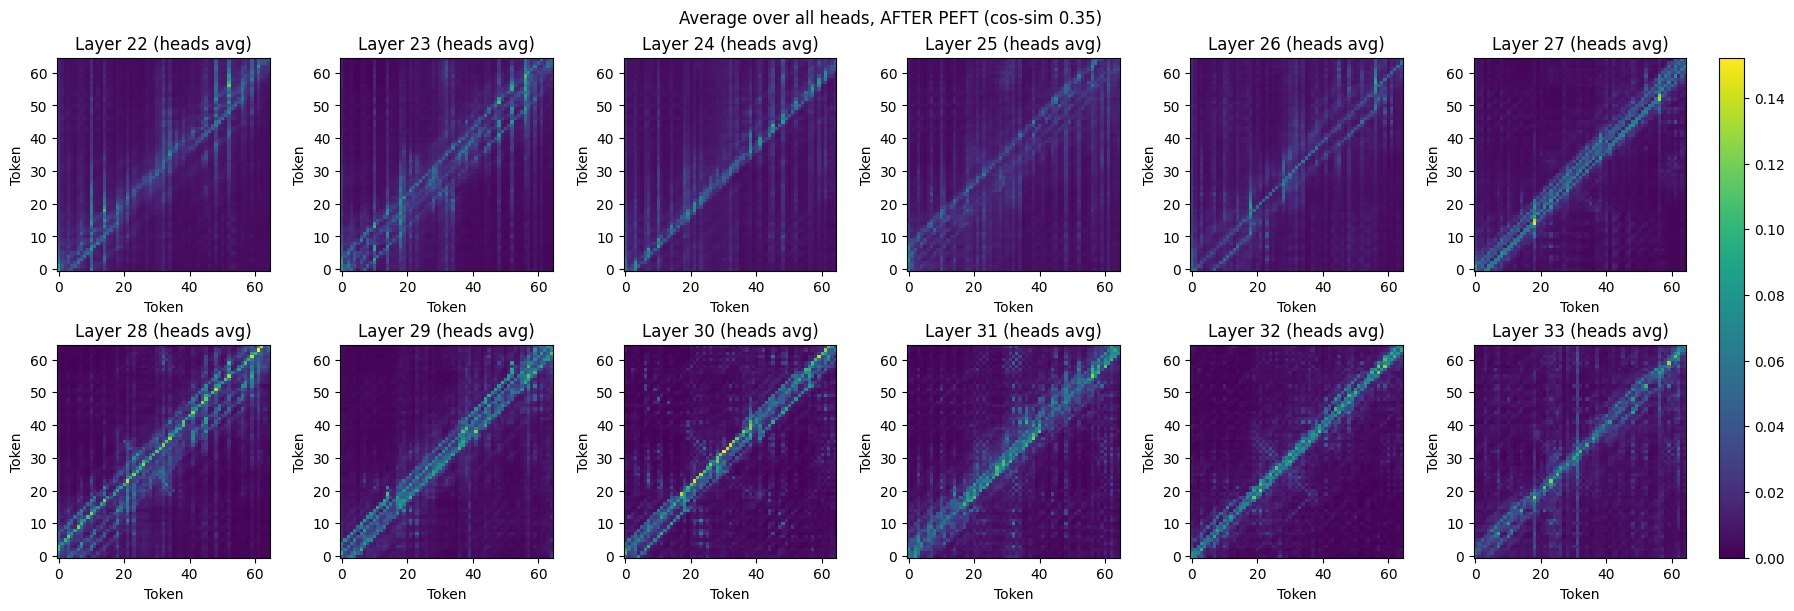

In [10]:
maps = avg_last8_layers_before  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        # im = ax.imshow(M, origin="lower", cmap="binary", vmin=vmin, vmax=vmax)
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Average over all heads, BEFORE PEFT")
plt.show()

maps = avg_last8_layers_after  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        # im = ax.imshow(M, origin="lower", cmap="binary", vmin=vmin, vmax=vmax)
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Average over all heads, AFTER PEFT (cos-sim 0.35)")
plt.show()

In [11]:
avg_last8_layers_diff = []
layers = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
for i in range(len(avg_last8_layers_before)):
    diff = avg_last8_layers_after[i] - avg_last8_layers_before[i]
    # print(f"Difference for layer {layers[i]}: {diff}")
    avg_last8_layers_diff.append(diff)

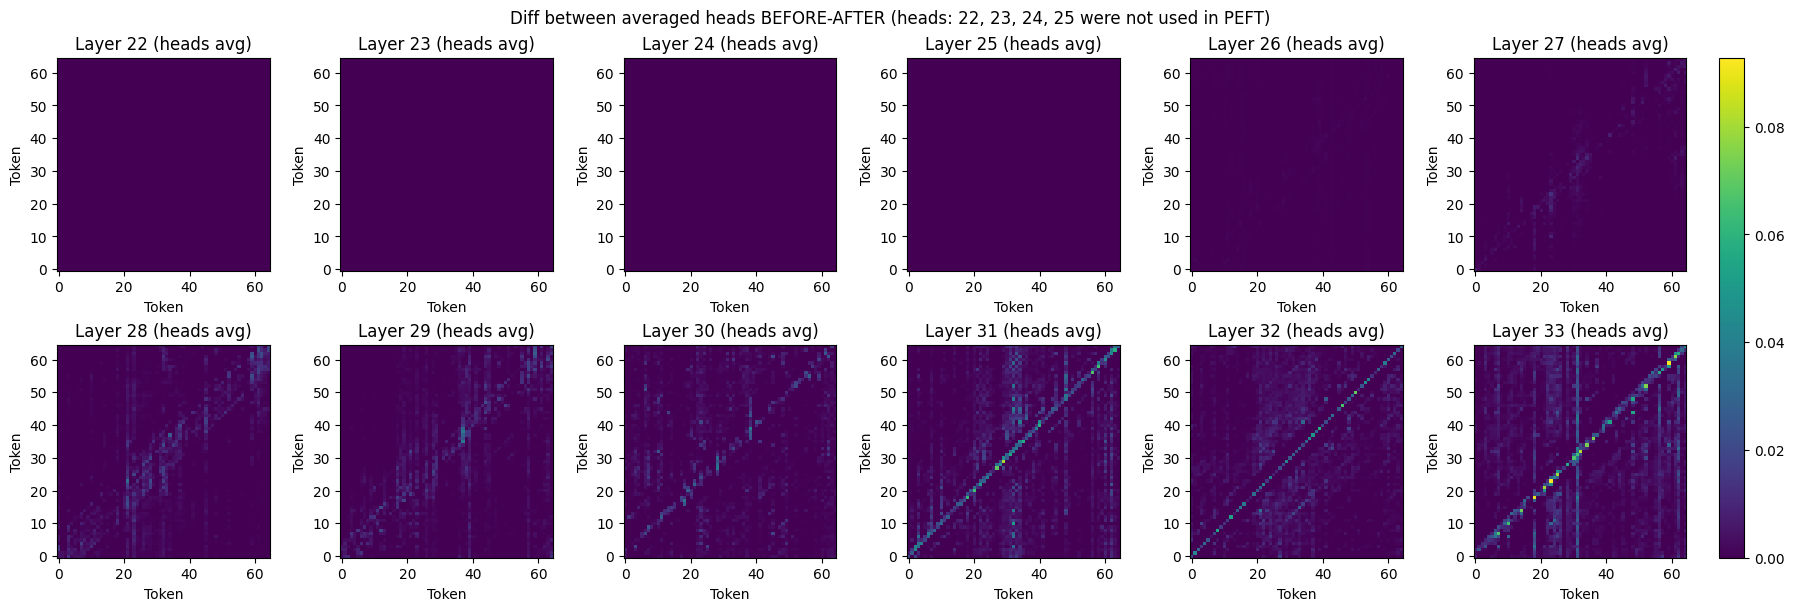

In [12]:
maps = avg_last8_layers_diff  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        # im = ax.imshow(M, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Diff between averaged heads BEFORE-AFTER (heads: 22, 23, 24, 25 were not used in PEFT)")
plt.show()

### Average over structure heads-only (12, 13, 19)

In [69]:
avg_last8_layers_before = []
for layer_attn in attentions_before[-12:]:
    A12 = layer_attn[0][11][1:-1, 1:-1]       # [H, T, T]
    A13 = layer_attn[0][12][1:-1, 1:-1]       # [H, T, T]
    A14 = layer_attn[0][13][1:-1, 1:-1]       # [H, T, T]
    A19 = layer_attn[0][18][1:-1, 1:-1]       # [H, T, T]
    Aav = (A12+A13+A14+A19)/4 
    avg_last8_layers_before.append(Aav) # [T, T]

avg_last8_layers_after = []
for layer_attn in attentions_after[-12:]:
    A12 = layer_attn[0][11][1:-1, 1:-1]       # [H, T, T]
    A13 = layer_attn[0][12][1:-1, 1:-1]       # [H, T, T]
    A14 = layer_attn[0][13][1:-1, 1:-1]       # [H, T, T]
    A19 = layer_attn[0][18][1:-1, 1:-1]       # [H, T, T]
    Aav = (A12+A13+A14+A19)/4 
    avg_last8_layers_after.append(Aav) # [T, T]

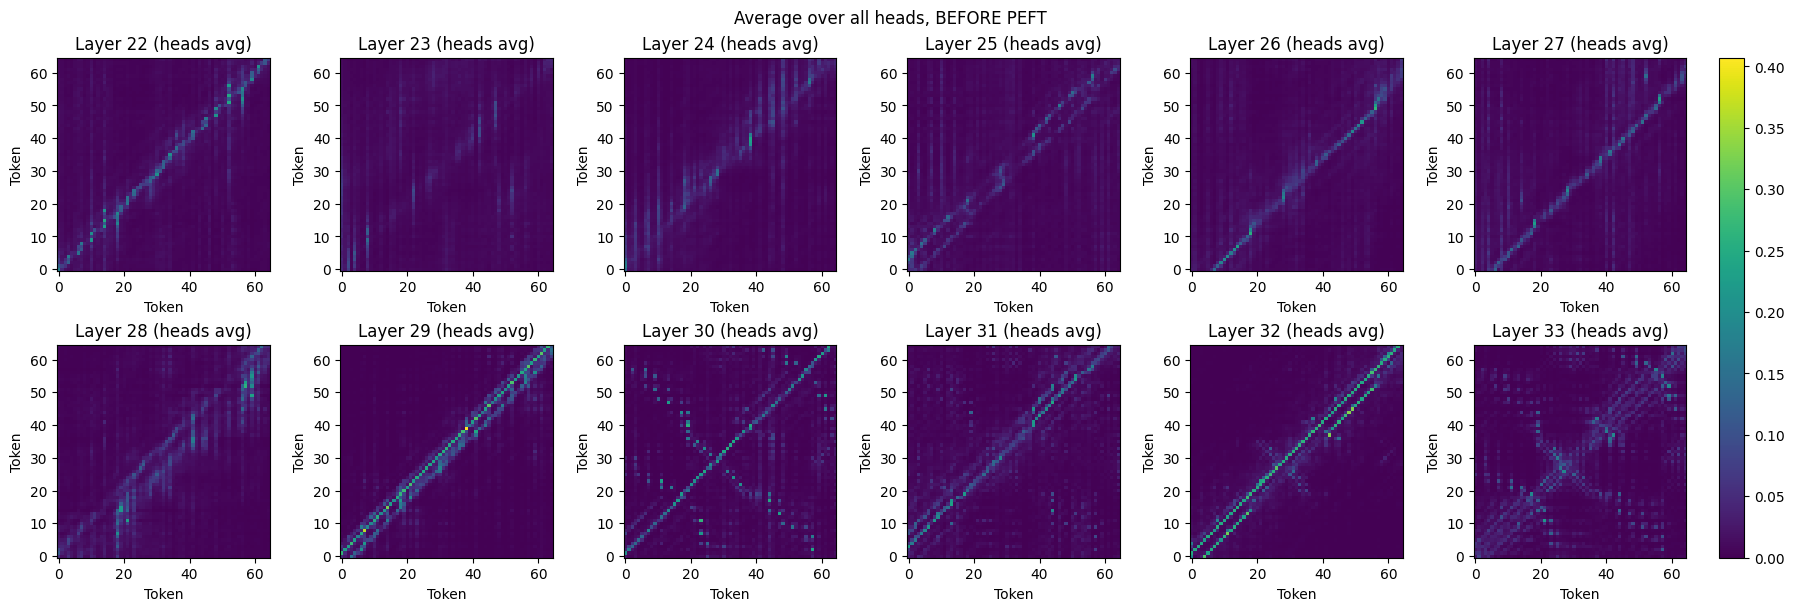

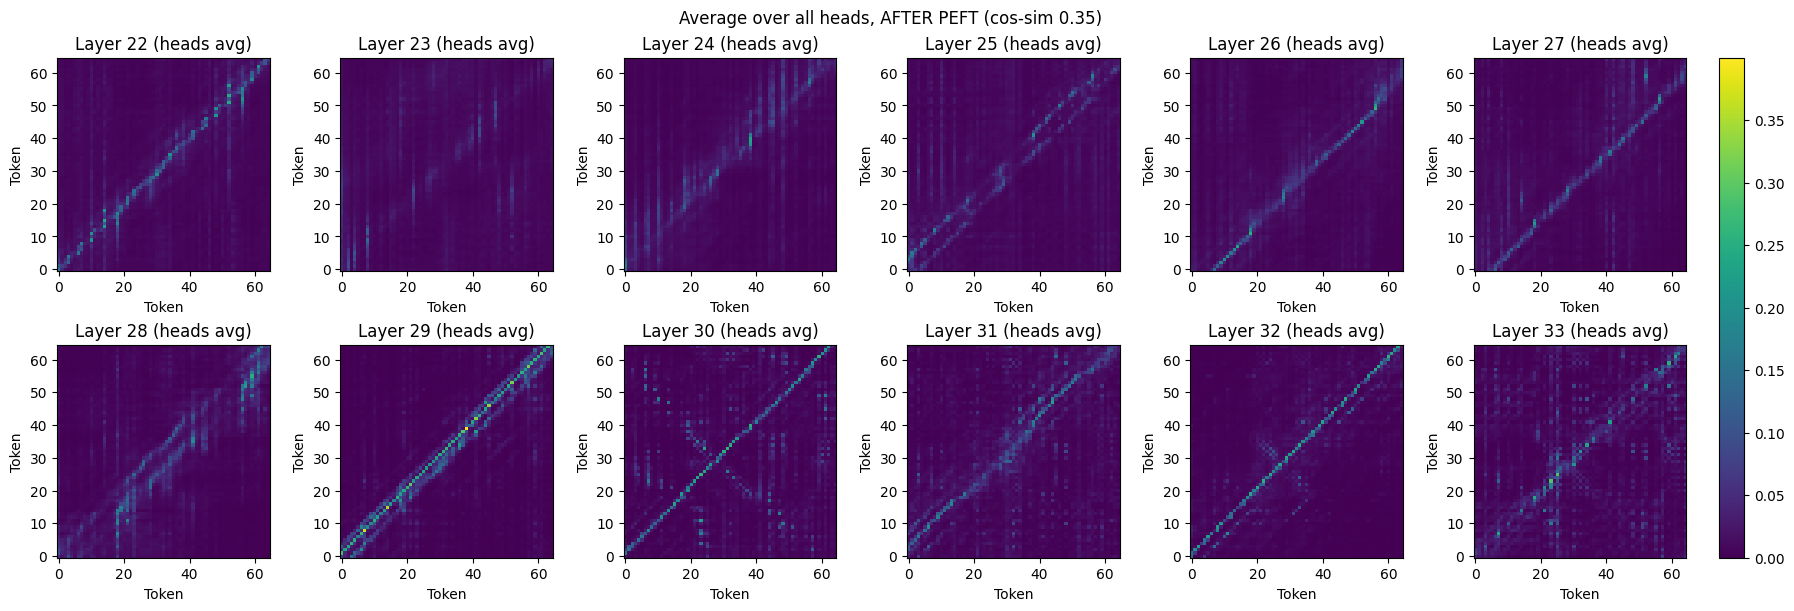

In [70]:
maps = avg_last8_layers_before  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        # im = ax.imshow(M, origin="lower", cmap="binary", vmin=vmin, vmax=vmax)
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Average over all heads, BEFORE PEFT")
plt.show()

maps = avg_last8_layers_after  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        # im = ax.imshow(M, origin="lower", cmap="binary", vmin=vmin, vmax=vmax)
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Average over all heads, AFTER PEFT (cos-sim 0.35)")
plt.show()

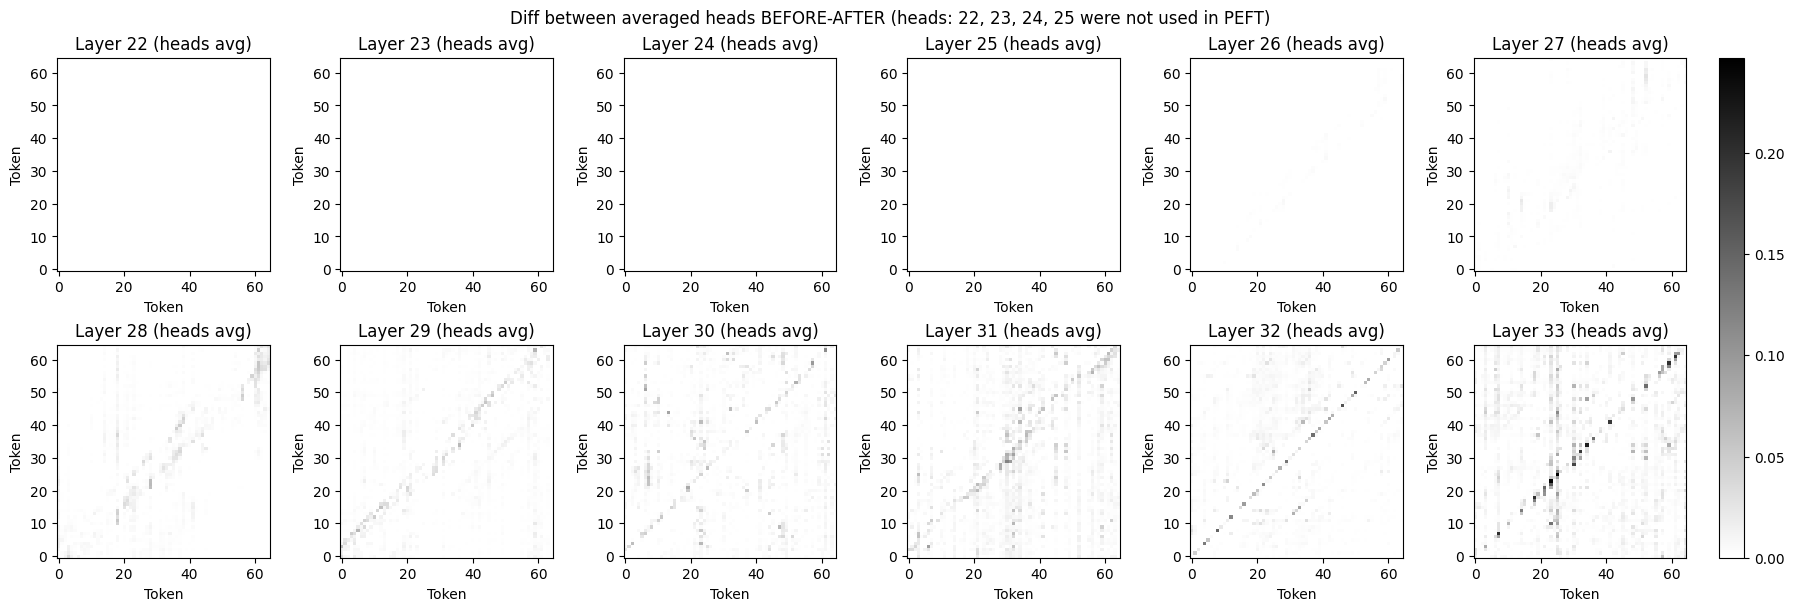

In [72]:
avg_last8_layers_diff = []
layers = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
for i in range(len(avg_last8_layers_before)):
    diff = avg_last8_layers_after[i] - avg_last8_layers_before[i]
    # print(f"Difference for layer {layers[i]}: {diff}")
    avg_last8_layers_diff.append(diff)

maps = avg_last8_layers_diff  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        im = ax.imshow(M, origin="lower", cmap="binary", vmin=0, vmax=vmax)
        # im = ax.imshow(M, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Diff between averaged heads BEFORE-AFTER (heads: 22, 23, 24, 25 were not used in PEFT)")
plt.show()

## Loss= token-level Loss

In [13]:
original_encoder = ESM2EncoderLoRA()
original_encoder.to("cuda")
original_encoder.eval()

### Training seq_down for 60 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.5.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")

seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to("cuda")
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.5.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")

seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to("cuda")
seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

In [14]:
### BEfore PEFT
attentions_before = original_encoder.get_attentions([random_sequence])
embeddings_before = original_encoder.forward([random_sequence])

### After PEFT
attentions_after = seq_encoder.get_attentions([random_sequence])
embeddings_after = seq_encoder.forward([random_sequence])

In [15]:
avg_last8_layers_before = []
for layer_attn in attentions_before[-12:]:
    A = layer_attn[0][:, 1:-1, 1:-1]       # [H, T, T]
    avg_last8_layers_before.append(A.mean(dim=0)) # [T, T]

avg_last8_layers_after = []
for layer_attn in attentions_after[-12:]:
    A = layer_attn[0][:, 1:-1, 1:-1]       # [H, T, T]
    avg_last8_layers_after.append(A.mean(dim=0)) # [T, T]

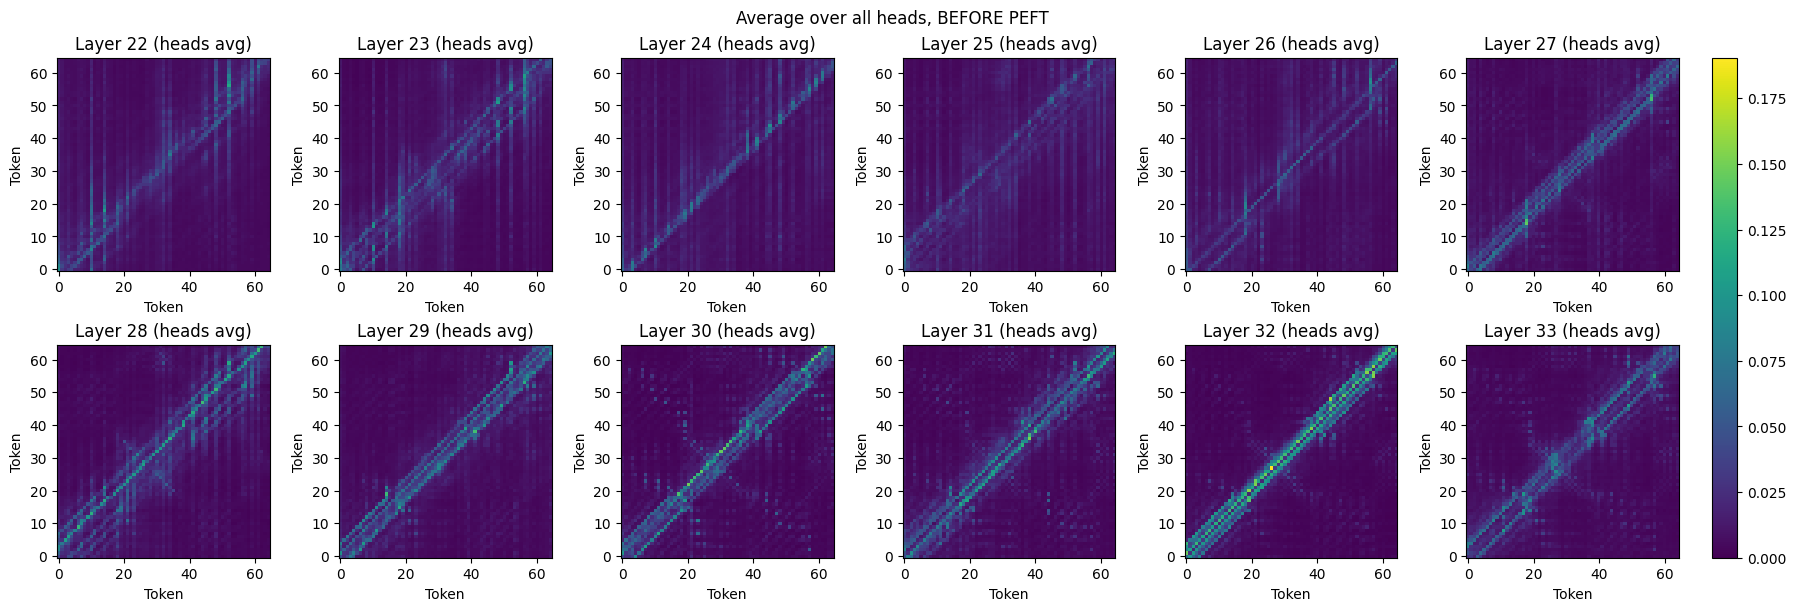

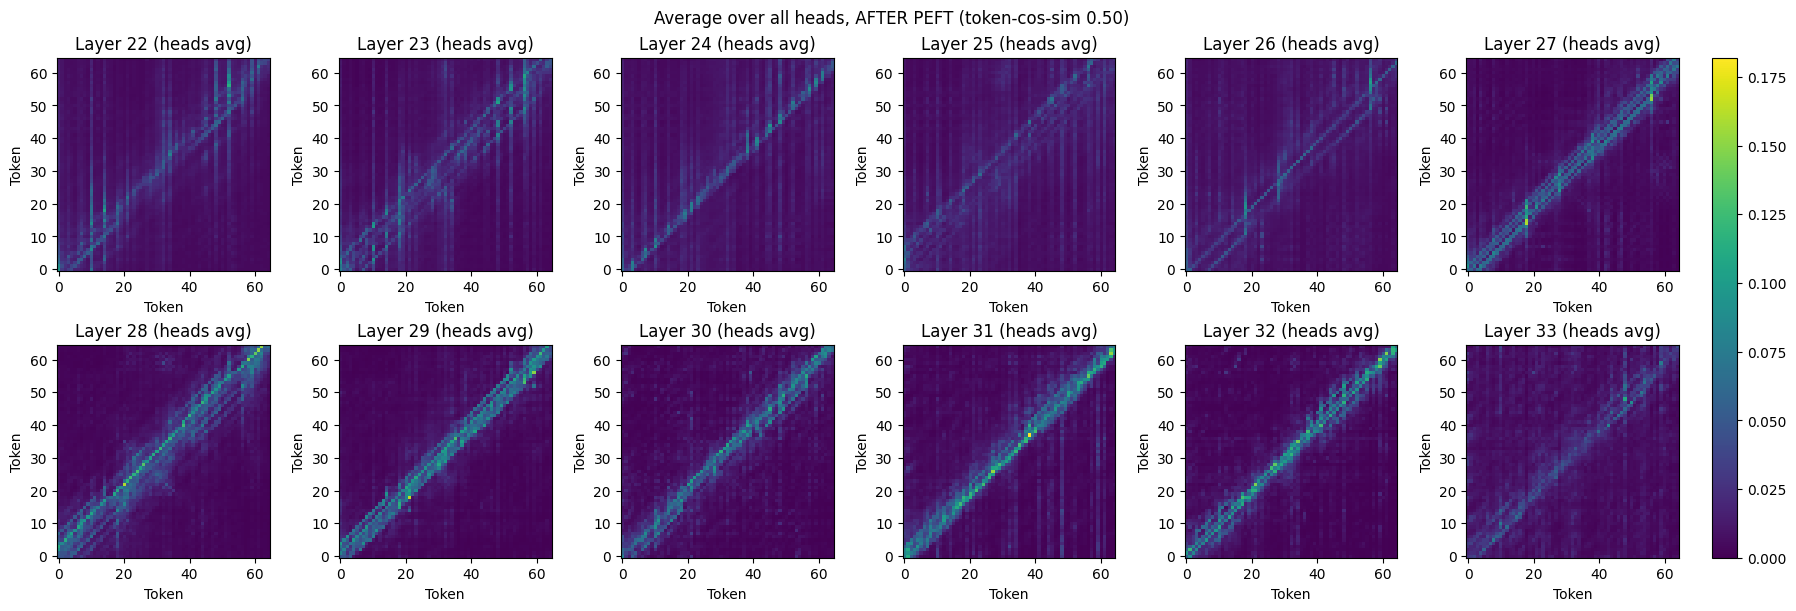

In [18]:
maps = avg_last8_layers_before  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        # im = ax.imshow(M, origin="lower", cmap="binary", vmin=vmin, vmax=vmax)
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Average over all heads, BEFORE PEFT")
plt.show()

maps = avg_last8_layers_after  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        # im = ax.imshow(M, origin="lower", cmap="binary", vmin=vmin, vmax=vmax)
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Average over all heads, AFTER PEFT (token-cos-sim 0.50)")
plt.show()

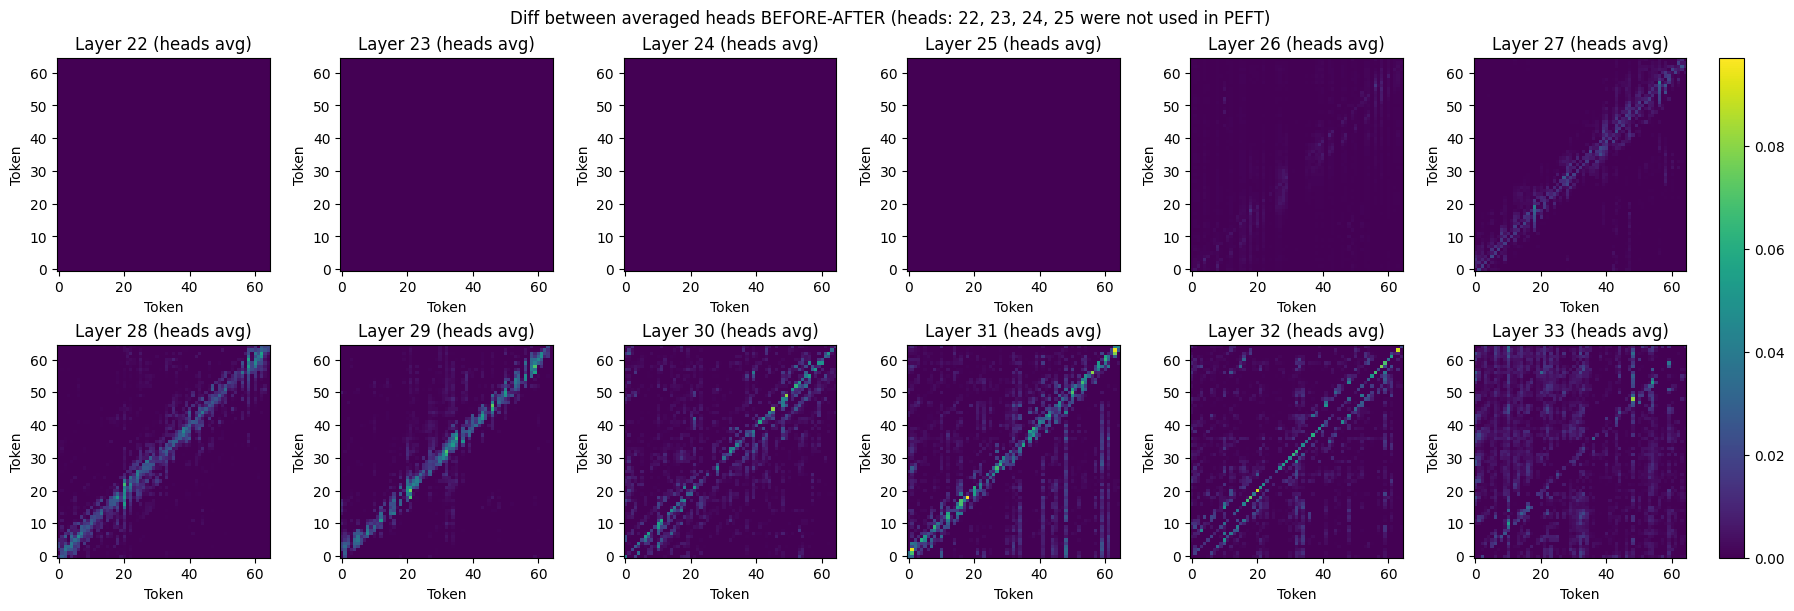

In [19]:
avg_last8_layers_diff = []
layers = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
for i in range(len(avg_last8_layers_before)):
    diff = avg_last8_layers_after[i] - avg_last8_layers_before[i]
    # print(f"Difference for layer {layers[i]}: {diff}")
    avg_last8_layers_diff.append(diff)

maps = avg_last8_layers_diff  # list of [T, T]
L = len(maps)

cols = 6
rows = math.ceil(L / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
axes = axes.ravel()

# shared color scale
vmin = float(torch.min(torch.stack([m.min() for m in maps])))
vmax = float(torch.max(torch.stack([m.max() for m in maps])))

for i in range(rows * cols):
    ax = axes[i]
    if i < L:
        M = maps[i].detach().cpu().numpy()
        im = ax.imshow(M, origin="lower", cmap="viridis", vmin=0, vmax=vmax)
        # im = ax.imshow(M, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(f"Layer {22 + i} (heads avg)")
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
    else:
        ax.axis("off")

fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
fig.suptitle("Diff between averaged heads BEFORE-AFTER (heads: 22, 23, 24, 25 were not used in PEFT)")
plt.show()

### Similarity ESM-2/ESM-IF

In [26]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def non_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings > (padding_value + offset)).all(dim=-1)

In [20]:
meta_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

meta_df["target_id_mod"] = [str("t_"+row.target_id) for __, row in meta_df.iterrows()]

# Interaction Dict
meta_df_shuffled = meta_df.sample(frac=1, random_state=0).reset_index(drop=True)

meta_df_shuffled_LONG_binder = meta_df_shuffled[["binder_id", "binder_seq", "seq_len_binder"]].rename(columns = {
    "binder_id" : "ID",
    "binder_seq" : "sequence",
    "seq_len_binder": "seq_len",
})

meta_df_shuffled_LONG_taget = meta_df_shuffled[["target_id_mod", "target_seq", "seq_len_target"]].rename(columns = {
    "target_id_mod" : "ID",
    "target_seq" : "sequence",
    "seq_len_target": "seq_len",
}).drop_duplicates(subset="ID", keep="first")

meta_df_shuffled_LONG = pd.concat([meta_df_shuffled_LONG_binder, meta_df_shuffled_LONG_taget], axis=0, ignore_index=True)
meta_df_shuffled_LONG

,ID,sequence,seq_len
0,FGFR2_124,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,62
1,EGFR_2_149,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,58
2,FGFR2_339,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,65
3,FGFR2_1234,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,64
4,IL2Ra_48,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,65
...,...,...,...
3543,t_SARS_CoV2_RBD,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,195
3544,t_VirB8,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,138
3545,t_sntx_2,MICHNQQSSQPPTTKTCSEGQCYKKTWRDHRGTIIERGCGCPTVKP...,60
3546,t_sntx,MICYNQQSSQPPTTKTCSETSCYKKTWRDHRGTIIERGCGCPKVKP...,60


In [21]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [22]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.seq_len = self.dframe["seq_len"].max()

        # index & storage
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"
               
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))[1:-1, :]
                emb_seq = np.load(os.path.join(esm2_path, f"{accession[2:]}.npy"))[1:-1, :]
                sequence = str(self.dframe.loc[accession].sequence)

                assert (emb_struct.shape[0]== emb_seq.shape[0] == len(sequence))

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"

                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))[1:-1, :]
                emb_seq = np.load(os.path.join(esm2_path, f"{accession}.npy"))[1:-1, :] 
                sequence = str(self.dframe.loc[accession].sequence)

                # print(emb_struct.shape, emb_seq.shape)
                assert (emb_struct.shape[0]== emb_seq.shape[0] == len(sequence))

            # quich check whether embedding dimmension is as it suppose to be
            if emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
            if emb_seq.shape[0] < self.seq_len:
                emb_seq = np.concatenate([emb_seq, np.full((self.seq_len - emb_seq.shape[0], emb_seq.shape[1]), self.emb_pad, dtype=emb_seq.dtype)], axis=0)
            else:
                emb_seq = emb_seq[: self.seq_len] # no padding was usedd

            if emb_struct.shape[0] < self.seq_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.seq_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.seq_len] # no padding was used

            self.samples.append((emb_seq, sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        emb_seq, seq, emb_struct = self.samples[idx]
        emb_seq, emb_struct = torch.from_numpy(emb_seq).float(), torch.from_numpy(emb_struct).float()
        # label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return emb_seq, seq, emb_struct

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        emb_seq_list, seqs_list, emb_struct_list = zip(*out)
    
        # Stack embeddings
        emb_seq_stacked  = torch.stack([torch.as_tensor(x) for x in emb_seq_list],  dim=0)  # [B, ...]        
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        # labels = torch.stack(lbl_list)  # [B]
    
        return emb_seq_stacked, seqs_list, emb_struct_stacked

emb_seq_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
emb_struct_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

meta_Dataset = CLIP_PPint_w_esmIF(
    meta_df_shuffled_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████████| 3548/3548 [00:17<00:00, 201.81it/s]


#### Heads before training

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:10<00:00, 34.78it/s]


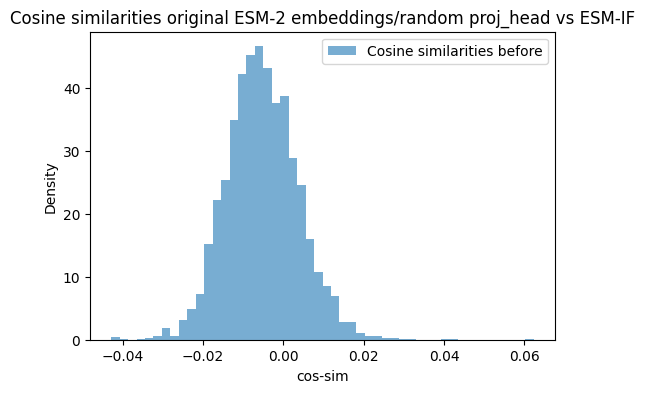

In [37]:
device = "cuda"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_before_training.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_before_training.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)

### Loading original embeddings and RANDOM projection head BEFORE
_loader = DataLoader(meta_Dataset, batch_size=10)
heads_before = []
padding_value = -5000.0

for batch in tqdm(_loader):
    seq_embed, __, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)

    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        # proj = model.seq_down(real_seq)      # [Li, 512]
        proj = seq_down(real_seq)
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    heads_before.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(heads_before, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities original ESM-2 embeddings/random proj_head vs ESM-IF")
plt.legend()
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████| 355/355 [01:04<00:00,  5.50it/s]


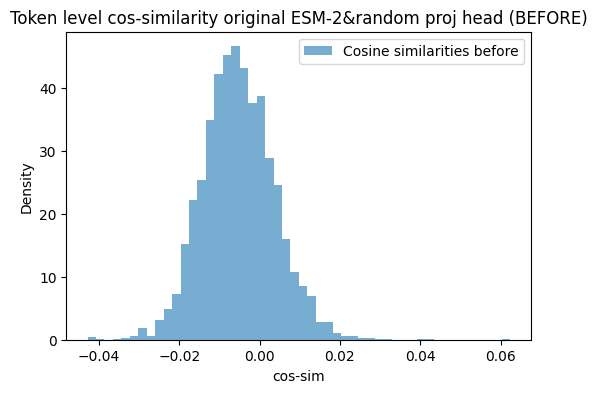

In [29]:
### Loading original ESM-2 embeddings and RANDOM projection head
_loader = DataLoader(meta_Dataset, batch_size=10)
heads_before = []
padding_value = -5000.0

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    heads_before.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(heads_before, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Token level cos-similarity original ESM-2&random proj head (BEFORE)")
plt.legend()
plt.show()

### Similarity 0.15

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████████| 355/355 [01:04<00:00,  5.50it/s]


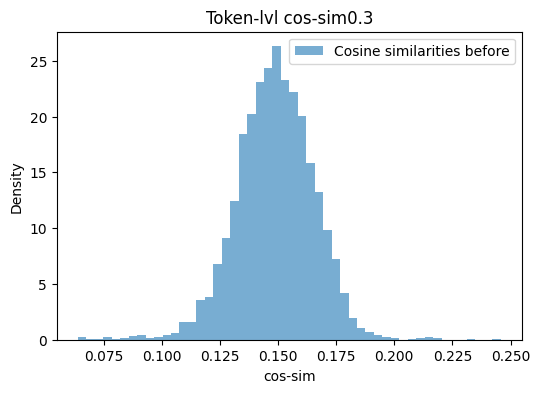

In [39]:
device = "cuda"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.15.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.15.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)

### Loading PRE-TRAINED heads
_loader = DataLoader(meta_Dataset, batch_size=10)
heads_cossim015 = []
padding_value = -5000.0

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls

    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    heads_cossim015.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(heads_cossim015, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Token-lvl cos-sim0.3")
plt.legend()
plt.show()

### Similarity 0.3 (right before feezing projection head, as it was trained for 4 epochs)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████████| 355/355 [01:04<00:00,  5.49it/s]


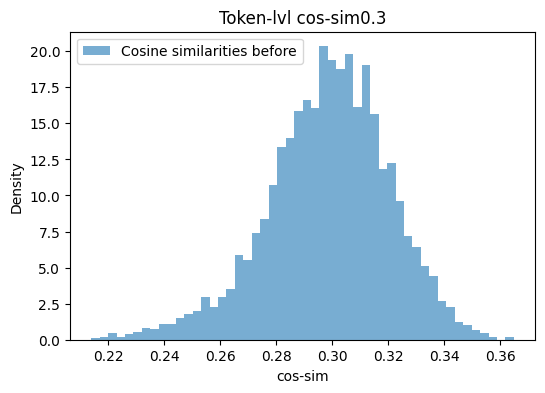

In [35]:
device = "cuda"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.3.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.3.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)

### Loading PRE-TRAINED heads
_loader = DataLoader(meta_Dataset, batch_size=10)
heads_cossim03 = []
padding_value = -5000.0

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls

    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    heads_cossim03.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(heads_cossim03, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Token-lvl cos-sim0.3")
plt.legend()
plt.show()

### Similarity 0.5

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████████| 355/355 [01:04<00:00,  5.48it/s]


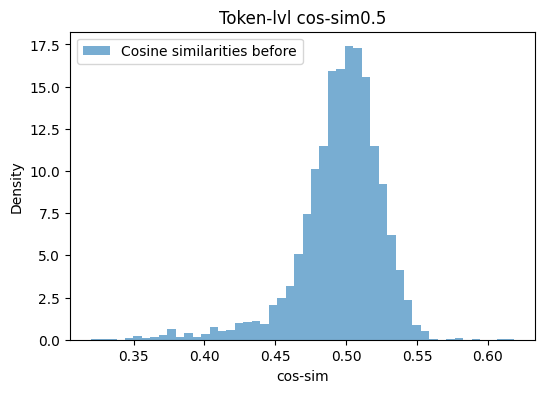

In [36]:
device = "cuda"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.5.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.5.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)

### Loading PRE-TRAINED heads
_loader = DataLoader(meta_Dataset, batch_size=10)
heads_cossim05 = []
padding_value = -5000.0

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls

    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    heads_cossim05.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(heads_cossim05, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Token-lvl cos-sim0.5")
plt.legend()
plt.show()

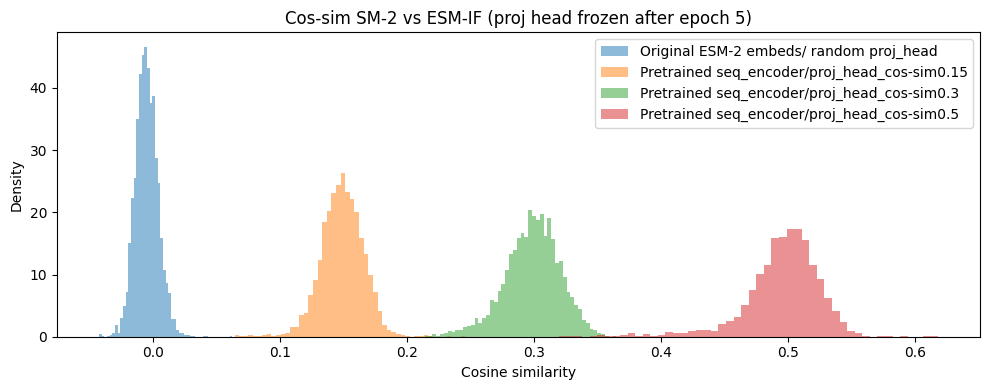

In [40]:
plt.figure(figsize=(10, 4))

plt.hist(heads_before, bins=50, alpha=0.5, label="Original ESM-2 embeds/ random proj_head", density=True)

plt.hist(heads_cossim015, bins=50, alpha=0.5, label="Pretrained seq_encoder/proj_head_cos-sim0.15", density=True)

plt.hist(heads_cossim03, bins=50, alpha=0.5, label="Pretrained seq_encoder/proj_head_cos-sim0.3", density=True)

plt.hist(heads_cossim05, bins=50, alpha=0.5, label="Pretrained seq_encoder/proj_head_cos-sim0.5", density=True)

plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.title("Cos-sim SM-2 vs ESM-IF (proj head frozen after epoch 5)")
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
api = wandb.Api()
entity, project = "s232958-danmarks-tekniske-universitet-dtu", "CSSP_token_level_similarity_Loss"
runs_weighting = api.runs(f"{entity}/{project}")

# Use the exact casing from your W&B logs
Keys = [
    "PPint Train-loss", "PPint Test-Loss", "Meta Val-loss", 
    "PPint non-dimer AUROC", "PPint non-dimer AUPR", "PPint Accuracy",
    "Meta Val-AUROC", "Meta Val-AUPR", "Meta Accuracy"
]

all_runs_list = [] 

print(f"Fetching history for {len(runs_weighting)} runs...")

for run in tqdm(runs_weighting):
    strategy = run.name
    
    # scan_history is the most reliable for capturing "Before training" + all epochs
    history = run.scan_history()

    # Initialize a dictionary of lists for this specific run
    run_data = {k: [] for k in Keys}
    run_data["epoch"] = []
    run_data["strategy"] = strategy

    for row in history:
        if any(k in row for k in Keys):
            for k in Keys:
                val = row.get(k)
                if val is not None:
                    run_data[k].append(val)
                elif val is None:
                    run_data[k].append(0)
            
            run_data["epoch"].append(row.get("_step", 0))

    temp_df = pd.DataFrame({k: run_data[k] for k in Keys + ["epoch"]})
    temp_df["strategy"] = strategy
    all_runs_list.append(temp_df)

# Combine all run DataFrames into one large master DataFrame
Df = pd.concat(all_runs_list, ignore_index=True)

# Verify Step 0
print(f"Total rows fetched: {len(Df)}")
print("First 5 steps for the first run:")
print(Df.head())

Fetching history for 7 runs...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]

Total rows fetched: 91
First 5 steps for the first run:
   PPint Train-loss  PPint Test-Loss  Meta Val-loss  PPint non-dimer AUROC  \
0          0.000000         6.248908      10.400999               0.648889   
1          0.554841         0.229265       0.428709               0.754750   
2          0.238812         0.215531       0.476416               0.763719   
3          0.188733         0.201623       0.423911               0.797582   
4          0.164270         0.197901       0.456387               0.804536   

   PPint non-dimer AUPR  PPint Accuracy  Meta Val-AUROC  Meta Val-AUPR  \
0              0.384316           0.838        0.511942       0.127292   
1              0.471101           0.860        0.475798       0.109450   
2              0.472352           0.888        0.463731       0.098099   
3              0.503837           0.882        0.483173       0.109775   
4              0.502668           0.890        0.504008       0.125785   

   Meta Accuracy  epoch       

In [46]:
Df = Df.rename(columns={
    "PPint Train-loss" : "train_loss", 
    "PPint Test-Loss" : "test_loss", 
    "Meta Val-loss" : "val_loss", 
    "PPint non-dimer AUROC" : "non_dimer_AUROC", 
    "PPint non-dimer AUPR" : "non_dimer_AUPR", 
    "PPint Accuracy" : "non_dimer_accuracy",
    "Meta Val-AUROC": "meta_AUROC", 
    "Meta Val-AUPR" : "meta_AUPR", 
    "Meta Accuracy" : "meta_accuracy"
})

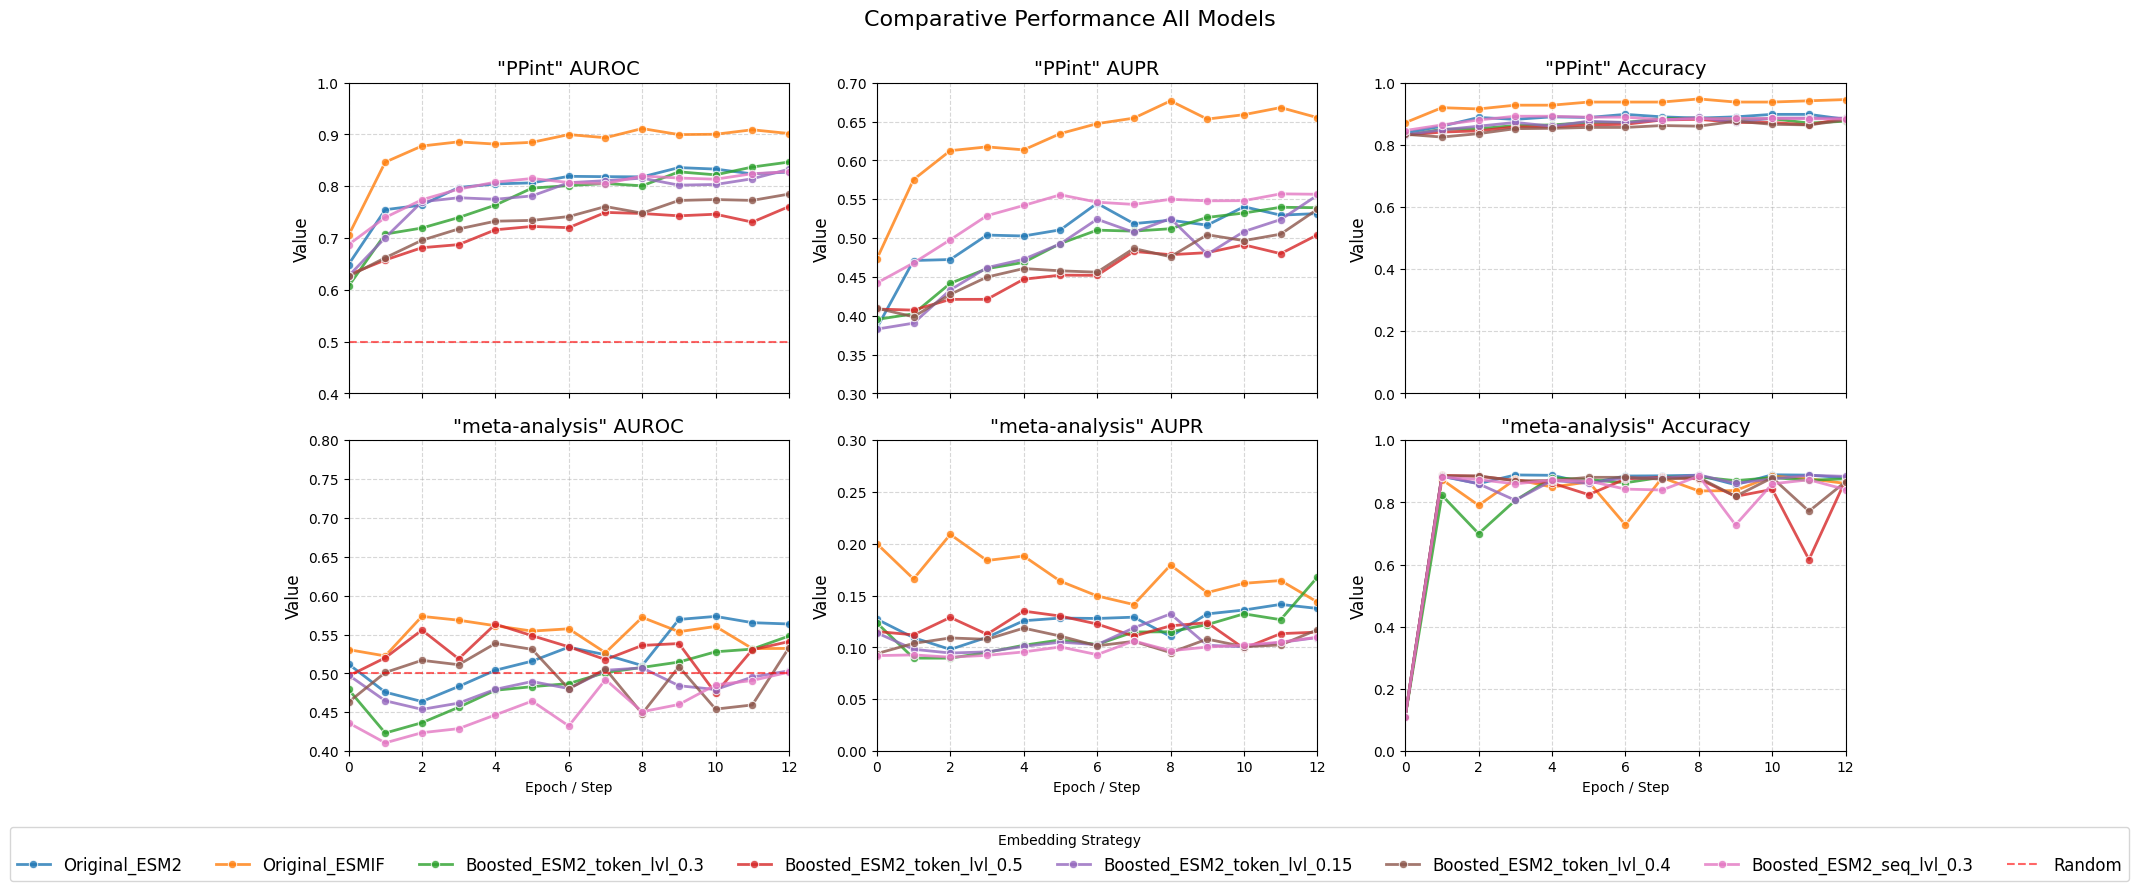

In [47]:
# 1. Define the metrics and their layout
# Top row: PPint (Train/Test) | Bottom row: Meta (Validation)
metrics = [
    "non_dimer_AUROC", "non_dimer_AUPR", "non_dimer_accuracy",
    "meta_AUROC", "meta_AUPR", "meta_accuracy"
]

titles = [
    '"PPint" AUROC', '"PPint" AUPR', '"PPint" Accuracy',
    '"meta-analysis" AUROC', '"meta-analysis" AUPR', '"meta-analysis" Accuracy'
]

# 2. Set up the figure (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
flat_axes = axes.flatten()

# 3. Plot each metric
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = flat_axes[i]
    
    # lineplot handles CV splits automatically (mean + confidence interval)
    sns.lineplot(
        data=Df, 
        x="epoch", 
        y=metric, 
        hue="strategy", 
        ax=ax, 
        marker='o', 
        linewidth=2,
        alpha=0.8
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Value", fontsize=12)
    ax.set_xlabel("Epoch / Step" if i >= 3 else "")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(0, 12)
    
    # Add random baseline (0.5) for AUROC plots
    if metric == "non_dimer_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 1.0)
    elif metric == "non_dimer_AUPR":
        ax.set_ylim(0.3, 0.7)
    elif metric == "non_dimer_accuracy":
        ax.set_ylim(0.0, 1.0)
    elif metric == "meta_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 0.8)
    elif metric == "meta_AUPR":
        ax.set_ylim(0.0, 0.3)
    elif metric == "meta_accuracy":
        ax.set_ylim(0.0, 1.0)

    # Remove individual legends to avoid clutter
    if ax.get_legend():
        ax.get_legend().remove()

# 4. Add a single global legend
handles, labels = flat_axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title="Embedding Strategy", 
    loc='lower center', 
    ncol=len(labels), 
    bbox_to_anchor=(0.5, -0.1),
    fontsize=12
)

plt.suptitle("Comparative Performance All Models", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()